# IBM Coursera Advanced Data Science Capstone
## Predict the genre of a book based on it's cover image

### Import the libraries which will be used in this project

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
%matplotlib inline

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190927065546-0001
KERNEL_ID = 357088fb-0daa-4776-9f9a-fa7d13dc892d


Using TensorFlow backend.


### Access permissions to the relevant data

In [2]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='###', project_access_token='###')
pc = project.project_context


In [3]:
# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials = {
    'IAM_SERVICE_ID': '###',
    'IBM_API_KEY_ID': '###',
    'ENDPOINT': '###',
    'IBM_AUTH_ENDPOINT': '###',
    'BUCKET': '###',
    'FILE': 'Dataset.zip'
}

### Get the dataset

In [4]:
import zipfile
def get_zip(file_name):
    '''
    file_name = Name of zip file you want to download from object storage
    '''
    try:
        fobj = open(file_name, "wb")
        fobj.write(project.get_file(file_name).read()) 
        fobj.close()
        z = zipfile.ZipFile(file_name)
        z.extractall()
    except Exception as e:
        print(Exception,e)
    else:
        print('Files downloaded successfully') 

In [5]:
get_zip('Dataset.zip')

Files downloaded successfully


### Read the csv file and print the names of the columns

In [6]:
train = pd.read_csv(project.get_file('train.csv'))
train.head()

,Id,genre,Biography,CHL-Fiction,Comics,Crime,Fantasy,Historical-Fiction,History,Romance,Sci-Fi,Thriller,Travel
0,9780094659902.jpg,['Biography'],1,0,0,0,0,0,0,0,0,0,0
1,9780094667501.jpg,['Biography'],1,0,0,0,0,0,0,0,0,0,0
2,9780094726208.jpg,['Biography'],1,0,0,0,0,0,0,0,0,0,0
3,9780094739307.jpg,['Biography'],1,0,0,0,0,0,0,0,0,0,0
4,9780094765801.jpg,['Biography'],1,0,0,0,0,0,0,0,0,0,0


In [7]:
train.columns

Index(['Id', 'genre', 'Biography', 'CHL-Fiction', 'Comics', 'Crime', 'Fantasy',
       'Historical-Fiction', 'History', 'Romance', 'Sci-Fi', 'Thriller',
       'Travel'],
      dtype='object')

### Get an idea of the average, minimum and maximum sizes of the book covers

In [8]:
heights = []
widths = []
for i in tqdm(range(train.shape[0])):
     img = image.load_img('Dataset/'+train['Id'][i])  
     img = image.img_to_array(img)
     heights.append(img.shape[0])
     widths.append(img.shape[1])

avg_height = sum(heights) / len(heights)
avg_width = sum(widths) / len(widths)
print("Average Height: " + str(avg_height))
print("Max Height: " + str(max(heights)))
print("Min Height: " + str(min(heights)))
print("Average Width: " + str(avg_width))
print("Max Width: " + str(max(widths)))
print("Min Width: " + str(min(widths)))

100%|██████████| 5500/5500 [00:51<00:00, 107.44it/s]

Average Height: 641.7654545454545
Max Height: 1260
Min Height: 150
Average Width: 417.2710909090909
Max Width: 942
Min Width: 93


### Load and preprocess the images

In [9]:
IMG_SIZE = 150

train_image = []
for i in tqdm(range(train.shape[0])):
    img = image.load_img('Dataset/'+train['Id'][i], target_size=(IMG_SIZE,IMG_SIZE,3)) 
    img = image.img_to_array(img)
    img = img.astype('float32') 
    img = img/255 
    train_image.append(img)
  
    
X = np.array(train_image)

100%|██████████| 5500/5500 [00:50<00:00, 108.50it/s]


### Verify the shape of the array and plot and visualise one of the images

In [10]:
X.shape

(5500, 150, 150, 3)

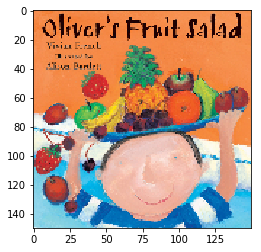

In [11]:
plt.imshow(X[600])

### Print the genre of this book

In [12]:
train['genre'][600]

"['CHL-Fiction']"

### Remove the Id and genre columns from the train file and convert the remaining columns to an array which will be the target for the images

In [13]:
y = np.array(train.drop(['Id', 'genre'],axis=1))
y.shape

(5500, 11)

### Create a validation set to check the performance of the model on unseen data by randomly separating 10% of the images as the validation set:

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

###  Define the architecture of the model. The output layer will have 11 neurons (equal to the number of genres) and will use sigmoid as the activation function.

In [15]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation="relu", input_shape=(IMG_SIZE,IMG_SIZE,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(11, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Print the model summary

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        18496     
__________

### Compile the model

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Train the model. The model will be trained for 20 epochs and also pass the validation data which was created earlier in order to validate the model’s performance:

In [18]:
hist = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=64)

Instructions for updating:
Use tf.cast instead.


Train on 4950 samples, validate on 550 samples
Epoch 1/20
4950/4950 [==============================] - 39s 8ms/step - loss: 0.4310 - acc: 0.8391 - val_loss: 0.3795 - val_acc: 0.9091
Epoch 2/20
4950/4950 [==============================] - 36s 7ms/step - loss: 0.3490 - acc: 0.9041 - val_loss: 0.3180 - val_acc: 0.9091
Epoch 3/20
4950/4950 [==============================] - 36s 7ms/step - loss: 0.3353 - acc: 0.9084 - val_loss: 0.3144 - val_acc: 0.9091
Epoch 4/20
4950/4950 [==============================] - 36s 7ms/step - loss: 0.3283 - acc: 0.9089 - val_loss: 0.3101 - val_acc: 0.9091
Epoch 5/20
4950/4950 [==============================] - 37s 7ms/step - loss: 0.3253 - acc: 0.9090 - val_loss: 0.3133 - val_acc: 0.9091
Epoch 6/20
4950/4950 [==============================] - 36s 7ms/step - loss: 0.3197 - acc: 0.9091 - val_loss: 0.3042 - val_acc: 0.9091
Epoch 7/20
4950/4950 [==============================] - 37s 7ms/step - loss: 0.3159 - acc: 0.9091 - val_loss: 0.3018 - val_acc: 0.9091
Epoch 8/

### Get the model's accuracy on the test data.

In [19]:
model.evaluate(X_test, y_test)[1]

550/550 [==============================] - 1s 2ms/step


0.913553755716844

### Visualize the model's accuracy

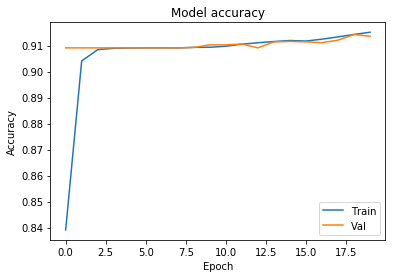

In [20]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

### Visualize the model's loss

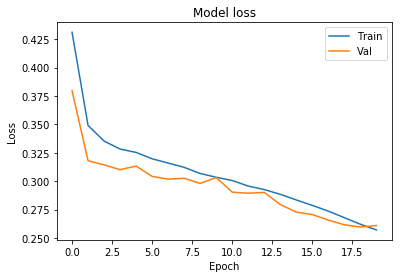

In [21]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### Make predictions on unseen images.
#### This is SciFi according to the publisher's classification

Travel (0.522)
History (0.0501)
Crime (0.048)


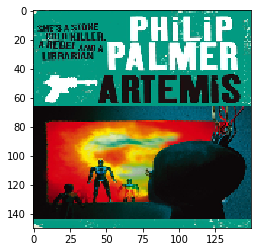

In [22]:
img = image.load_img('Dataset/9781841499451.jpg',target_size=(IMG_SIZE,IMG_SIZE,3))
img = image.img_to_array(img)
img = img/255

classes = np.array(train.columns[2:])
proba = model.predict(img.reshape(1,IMG_SIZE,IMG_SIZE,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)

#### This is a Thriller according to the publisher's classification

Thriller (0.173)
Crime (0.171)
History (0.141)


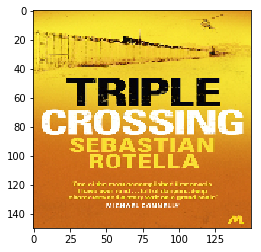

In [23]:
img = image.load_img('Dataset/9781444727531.jpg',target_size=(IMG_SIZE,IMG_SIZE,3))
img = image.img_to_array(img)
img = img/255

classes = np.array(train.columns[2:])
proba = model.predict(img.reshape(1,IMG_SIZE,IMG_SIZE,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)

#### This is a Travel book according to the publisher's classification

Travel (0.998)
CHL-Fiction (0.00323)
History (0.0012)


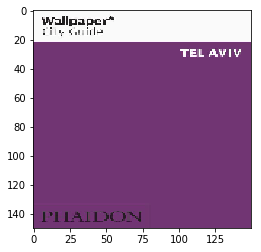

In [24]:
img = image.load_img('Dataset/9780714862071.jpg',target_size=(IMG_SIZE,IMG_SIZE,3))
img = image.img_to_array(img)
img = img/255

classes = np.array(train.columns[2:])
proba = model.predict(img.reshape(1,IMG_SIZE,IMG_SIZE,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)

#### This is a Comic according to the publisher's classification

Comics (0.397)
CHL-Fiction (0.155)
Historical-Fiction (0.0924)


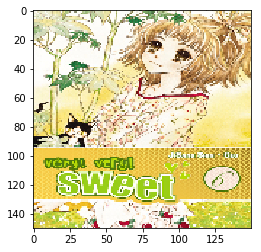

In [25]:
img = image.load_img('Dataset/9780759531499.jpg',target_size=(IMG_SIZE,IMG_SIZE,3))
img = image.img_to_array(img)
img = img/255

classes = np.array(train.columns[2:])
proba = model.predict(img.reshape(1,IMG_SIZE,IMG_SIZE,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)

#### This is Children Fiction according to the publisher's classification

CHL-Fiction (0.276)
History (0.123)
Travel (0.122)


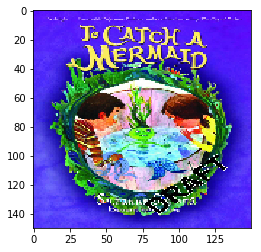

In [26]:
img = image.load_img('Dataset/9780316018173.jpg',target_size=(IMG_SIZE,IMG_SIZE,3))
img = image.img_to_array(img)
img = img/255

classes = np.array(train.columns[2:])
proba = model.predict(img.reshape(1,IMG_SIZE,IMG_SIZE,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)

#### This is Crime according to the publisher's classification

Sci-Fi (0.186)
History (0.159)
Biography (0.136)


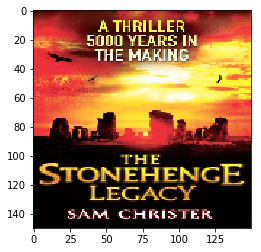

In [27]:
img = image.load_img('Dataset/9780751545180.jpg',target_size=(IMG_SIZE,IMG_SIZE,3))
img = image.img_to_array(img)
img = img/255

classes = np.array(train.columns[2:])
proba = model.predict(img.reshape(1,IMG_SIZE,IMG_SIZE,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)

#### This is Fantasy according to the publisher's classification

Thriller (0.282)
Crime (0.219)
Sci-Fi (0.157)


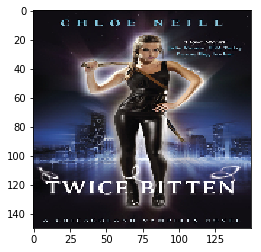

In [28]:
img = image.load_img('Dataset/9780575099371.jpg',target_size=(IMG_SIZE,IMG_SIZE,3))
img = image.img_to_array(img)
img = img/255

classes = np.array(train.columns[2:])
proba = model.predict(img.reshape(1,IMG_SIZE,IMG_SIZE,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)

#### This is Romance according to the publisher's classification

Biography (0.189)
Historical-Fiction (0.138)
Romance (0.134)


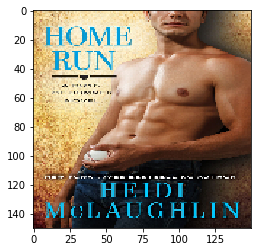

In [29]:
img = image.load_img('Dataset/9781455598274.jpg',target_size=(IMG_SIZE,IMG_SIZE,3))
img = image.img_to_array(img)
img = img/255

classes = np.array(train.columns[2:])
proba = model.predict(img.reshape(1,IMG_SIZE,IMG_SIZE,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)

#### Save the model.
#### To load it:
from keras.models import load_model  
model = load_model('model_150.h5')

In [30]:
model.save('model_150.h5')